<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Graph%20Neural%20Network/Graph_Neural_Network_in_Natural_Language_processing_with_spacexdataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 212.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 21.8 MB/s eta 0:00:00


In [ ]:
!kaggle datasets download -d gallo33henrique/twitter-nlp-spacex

Dataset URL: https://www.kaggle.com/datasets/gallo33henrique/twitter-nlp-spacex
License(s): MIT
  0% 0.00/28.1k [00:00<?, ?B/s]
100% 28.1k/28.1k [00:00<00:00, 55.4MB/s]


import library

In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import random
import math
import os
import matplotlib.pyplot as plt
import string

import spacy
from spacy.tokens import Doc
from spacy import displacy
from scipy.sparse import coo_matrix

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import lr_scheduler
from torch_geometric.data import Data

from torch_geometric.data import InMemoryDataset
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, TransformerConv, GATv2Conv, ChebConv, ResGatedGraphConv
import torch_geometric.nn as pyg_nn
from torch_geometric.loader import DataLoader

Read the data


In [ ]:
df_train = pd.read_csv('/content/dataset_spacex.csv')

In [ ]:
df_train.head()

,Id,Text,Subjectivity,Polarity,Target
0,0,SpaceX software team will do an AMA tomorrow on,0.000000,0.0,Neutral
1,1,"Targeting Saturday, May 15 at 6:54 p.m. EDT fo...",0.000000,0.0,Neutral
2,2,SpaceX’s fifth high-altitude flight test of St...,0.000000,0.0,Neutral
3,3,First Falcon 9 first stage to complete 10 laun...,0.355556,0.2,Positive
4,4,Geometric Energy Corporation proudly announces...,0.500000,0.4,Positive


In [ ]:
df_train = pd.concat([df_train, df_train["Target"].str.get_dummies()], axis=1, join='inner')
df_train.drop(["Target"], axis=1, inplace=True)
df_train.head()

,Id,Text,Subjectivity,Polarity,Negative,Neutral,Positive
0,0,SpaceX software team will do an AMA tomorrow on,0.000000,0.0,0,1,0
1,1,"Targeting Saturday, May 15 at 6:54 p.m. EDT fo...",0.000000,0.0,0,1,0
2,2,SpaceX’s fifth high-altitude flight test of St...,0.000000,0.0,0,1,0
3,3,First Falcon 9 first stage to complete 10 laun...,0.355556,0.2,0,0,1
4,4,Geometric Energy Corporation proudly announces...,0.500000,0.4,0,0,1


In [ ]:
target_col_names = df_train.columns[-3:].tolist()
target_col_names

['Negative', 'Neutral', 'Positive']

Build a tokenizer and dependency graph

In [ ]:
class Tokenizer(object):
    def __init__(self, word2idx=None, nlp_model="en_core_web_sm"):
        # https://spacy.io/docs/usage/processing-text
        self.nlp = spacy.load(nlp_model)
        if word2idx is None:
            self.word2idx = {}
            self.idx2word = {}
            self.idx = 0
            self.word2idx['<pad>'] = self.idx  # '<pad>': 0
            self.idx2word[self.idx] = '<pad>'
            self.idx += 1
            self.word2idx['<unk>'] = self.idx  # '<unk>': 1
            self.idx2word[self.idx] = '<unk>'
            self.idx += 1
        else:
            self.word2idx = word2idx
            self.idx2word = {v:k for k,v in word2idx.items()}

    def fit_on_doc(self, doc:spacy.tokens.doc.Doc):
        for word in doc:
            word = str(word).lower()
            if word not in self.word2idx:
                self.word2idx[word] = self.idx
                self.idx2word[self.idx] = word
                self.idx += 1

    def text_to_doc(self, text):
        return self.nlp(text)

    def doc_to_sequence(self, doc:spacy.tokens.doc.Doc):
        sequence = []
        for w in doc:
            w = str(w).lower()
            word_id = self.word2idx.get(w, -1)
            if word_id == -1:
                word_id = self.word2idx['<unk>']
            sequence.append(word_id)
        if len(sequence) == 0:
            sequence = [0]
        return np.array(sequence, dtype=np.int32)


    def doc_to_adj(self, doc:spacy.tokens.doc.Doc):
        matrix = np.zeros((len(doc), len(doc))).astype('int32')
        for token in doc:
            for child in token.children:
                matrix[token.i][child.i] = 1
                matrix[child.i][token.i] = 1
        return matrix


In [ ]:
tokenizer = Tokenizer()

In [ ]:
idx2graph = {}
for i in tqdm(range(df_train.shape[0])):
    text = df_train.Text[i].lower().replace("\n", "").strip()
    doc = tokenizer.text_to_doc(text)
    tokenizer.fit_on_doc(doc)
    adj_matrix = tokenizer.doc_to_adj(doc)
    coo = coo_matrix(adj_matrix)
    idx2graph[i] = np.array([coo.row, coo.col], dtype=np.int32)

  0%|          | 0/941 [00:00<?, ?it/s]

In [ ]:
idx2graph[0]

array([[0, 1, 2, 2, 2, 3, 4, 4, 4, 4, 4, 5, 6, 6, 7, 8],
       [2, 2, 0, 1, 4, 4, 2, 3, 6, 7, 8, 6, 4, 5, 4, 4]], dtype=int32)

In [ ]:
idx2graph[0].shape

(2, 16)

In [ ]:
text = df_train.Text[0].lower().replace("\n", "").strip()
doc = tokenizer.nlp(text)
print ("{:<15} | {:<8} | {:<15} | {:<20}".format('Token','Relation','Head', 'Spacex'))
print ("-" * 70)
for token in doc:
  print ("{:<15} | {:<8} | {:<15} | {:<20}"
         .format(str(token.text), str(token.dep_), str(token.head.text), str([child for child in token.children])))

Token           | Relation | Head            | Spacex              
----------------------------------------------------------------------
spacex          | compound | team            | []                  
software        | compound | team            | []                  
team            | nsubj    | do              | [spacex, software]  
will            | aux      | do              | []                  
do              | ROOT     | do              | [team, will, ama, tomorrow, on]
an              | det      | ama             | []                  
ama             | dobj     | do              | [an]                
tomorrow        | npadvmod | do              | []                  
on              | prep     | do              | []                  


In [ ]:
displacy.render(doc, style='dep', jupyter=True)

Build the embedding

In [ ]:
def load_word_vec(path, word2idx=None, embed_dim=300):
    fin = open(path, 'r', encoding='utf-8', newline='\n', errors='ignore')
    word_vec = {}
    for line in fin:
        tokens = line.rstrip().split()
        word, vec = ' '.join(tokens[:-embed_dim]), tokens[-embed_dim:]
        if word in word2idx.keys():
            word_vec[word] = np.array(vec, dtype=np.float32)
    return word_vec

def build_embedding_matrix(word2idx, embed_dim=300):
    embedding_matrix = np.zeros((len(word2idx), embed_dim))
    embedding_matrix[1, :] = np.random.uniform(-1/np.sqrt(embed_dim), 1/np.sqrt(embed_dim), (1, embed_dim))

    fname = '../content/glove.840B.300d.txt'
    word_vec = load_word_vec(fname, word2idx=word2idx, embed_dim=embed_dim)

    for word, i in word2idx.items():
        vec = word_vec.get(word)
        if vec is not None:
            embedding_matrix[i] = vec

    return embedding_matrix

In [ ]:
embedding_matrix = build_embedding_matrix(tokenizer.word2idx, 300)

In [ ]:
embedding_matrix.shape

(1806, 300)

Dataset

In [ ]:
class MyTrainDataset(InMemoryDataset):

  def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
    super().__init__(root, transform, pre_transform, pre_filter)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_dir(self):
    return "/content"

  @property
  def processed_dir(self):
    return os.path.join(self.root, "train_processed")


  @property
  def raw_file_names(self):   # -> List[str]:
    return ['dataset_spacex.csv']


  @property
  def processed_file_names(self) -> str:
    return ['data.pt']

  def download(self):
    pass


  def process(self):
    data_list = self.read_data()

    if self.pre_filter is not None:
      data_list = [data for data in data_list if self.pre_filter(data)]

    if self.pre_transform is not None:
      data_list = [self.pre_transform(data) for data in data_list]

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])


  def read_data(self):
    df_train = pd.read_csv(self.raw_paths[0])
    all_data = []

    for i in range(df_train.shape[0]):
      text = df_train.Text[i].lower().replace("\n", "").strip()

      #df_train.Text[0].lower().replace("\n", "").strip()


      doc = tokenizer.text_to_doc(text)

      input_ids = tokenizer.doc_to_sequence(doc)

      label = df_train.loc[i, ['Subjectivity']].to_list()
      x = torch.tensor(input_ids.reshape(-1, 1), dtype=torch.int32)
      edge_index  = torch.tensor(idx2graph[i], dtype=torch.long)
      y = torch.tensor(np.array(label), dtype=torch.float32).reshape(-1, 1)
      data = Data(x=x, edge_index=edge_index, y=y)

      all_data.append(data)



    return all_data

In [ ]:
dataset = MyTrainDataset(root = "data/")

Processing...
Done!


In [ ]:
print(dataset.raw_paths, dataset.processed_paths)

['/content/dataset_spacex.csv'] ['data/train_processed/data.pt']


In [ ]:
dataset.data

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[15499, 1], edge_index=[2, 28596], y=[941, 1])

In [ ]:
dataset[0]

Data(x=[24, 1], edge_index=[2, 46], y=[1, 1])

In [ ]:
dataset[0].y

tensor([[0.5000]])

In [ ]:
dataset = dataset.shuffle()
train_len = int(0.8*len(dataset))
train_dataset = dataset[:train_len]
val_dataset = dataset[train_len:]
print(len(train_dataset), len(val_dataset))

752 189


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

In [ ]:
for i in train_loader:
    print(i)

DataBatch(x=[2078, 1], edge_index=[2, 3850], y=[128, 1], batch=[2078], ptr=[129])
DataBatch(x=[2101, 1], edge_index=[2, 3864], y=[128, 1], batch=[2101], ptr=[129])
DataBatch(x=[2173, 1], edge_index=[2, 4008], y=[128, 1], batch=[2173], ptr=[129])
DataBatch(x=[2242, 1], edge_index=[2, 4148], y=[128, 1], batch=[2242], ptr=[129])
DataBatch(x=[2046, 1], edge_index=[2, 3776], y=[128, 1], batch=[2046], ptr=[129])
DataBatch(x=[1894, 1], edge_index=[2, 3508], y=[112, 1], batch=[1894], ptr=[113])


Create Model


In [ ]:
class FeedbackModel(nn.Module):
  def __init__(self, embedding_matrix):

    super(FeedbackModel, self).__init__()

    self.embed = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float), freeze=False)

    self.gc1   = GCNConv(300, 128)
    self.pool1 = pyg_nn.TopKPooling(128, ratio=0.8)
    self.gc2   = GCNConv(128, 128)
    self.pool2 = pyg_nn.TopKPooling(128, ratio=0.8)
    self.lin1  = nn.Linear(256, 64)
    self.lin2  = nn.Linear(64, 1)

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch

    x = x.squeeze(1)
    x = self.embed(x)

    x = F.relu(self.gc1(x, edge_index))
    x, edge_index, edge_attr, batch, perm, score = self.pool1(x, edge_index, None, batch)
    x1 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

    x = F.relu(self.gc2(x, edge_index))
    x, edge_index, edge_attr, batch, perm, score = self.pool2(x, edge_index, None, batch)
    x2 = torch.cat([pyg_nn.global_max_pool(x, batch), pyg_nn.global_mean_pool(x, batch)], dim=1)

    x = x1 + x2
    # x, hn = self.gru(x, None)
    x = F.relu(self.lin1(x))
    x = F.dropout(x, p=0.5, training=self.training)
    output = F.relu(self.lin2(x))

    return output

In [ ]:
model = FeedbackModel(embedding_matrix)
model

FeedbackModel(
  (embed): Embedding(1806, 300)
  (gc1): GCNConv(300, 128)
  (pool1): TopKPooling(128, ratio=0.8, multiplier=1.0)
  (gc2): GCNConv(128, 128)
  (pool2): TopKPooling(128, ratio=0.8, multiplier=1.0)
  (lin1): Linear(in_features=256, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=1, bias=True)
)

In [ ]:
epochs = 100

criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=1e-5)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=6)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

MSELoss()

Train

In [ ]:
total_loss = []
for epoch_num in range(epochs):
  model.train()
  total_loss_train = 0
  for sample_batched in train_loader:
    sample_batched = sample_batched.to(device)
    optimizer.zero_grad()
    outputs = model(sample_batched)
    label = sample_batched.y.to(device)
#   print(outputs.shape, label.shape)
    loss = criterion(outputs, label)
    loss.backward()
    total_loss_train += loss.item()
    optimizer.step()

  model.eval()
  total_loss_val = 0
  with torch.no_grad():
    for sample_batched in val_loader:
      sample_batched = sample_batched.to(device)
      outputs = model(sample_batched)
      label = sample_batched.y.to(device)
      loss = criterion(outputs, label)
      total_loss_val += loss.item()

    scheduler.step(total_loss_val / len(val_dataset))

    print(f'Epoch: %02.0f | Train Loss: {total_loss_train / len(train_dataset): .3f} | Val Loss: {total_loss_val / len(val_dataset): .3f}' % (epoch_num + 1))

    total_loss.append([total_loss_train / len(train_dataset), total_loss_val / len(val_dataset)])

Epoch: 01 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 02 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 03 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 04 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 05 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 06 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 07 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 08 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 09 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 10 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 11 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 12 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 13 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 14 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 15 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 16 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 17 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 18 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 19 | Train Loss:  0.000 | Val Loss:  0.001
Epoch: 20 | Train Loss:  0.000 | Val Loss:  0.001


In [ ]:
total_loss = np.array(total_loss, dtype=np.float32)

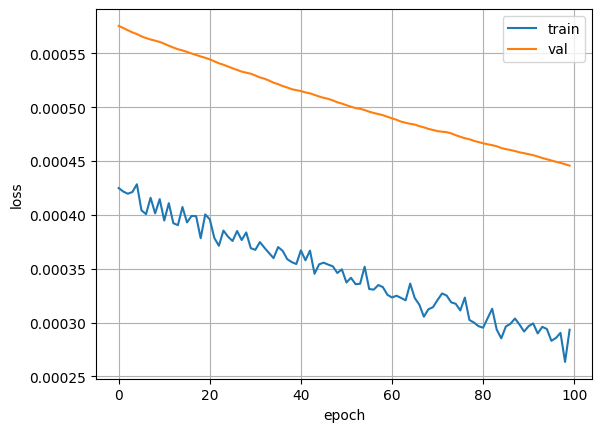

In [ ]:
plt.figure()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(total_loss[:,0], '-', label="train")
plt.plot(total_loss[:,1], '-', label="val")
plt.legend()
plt.grid(True)
plt.show()